In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [9]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
print("Tensorflow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

Tensorflow v2.15.0
TensorFlow Decision Forests v1.8.1


## Load Dataset

In [11]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [12]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


id와 index를 제외한 총 79개의 열이 존재

- SalePrice 컬럼을 예측해야되는 task

In [13]:
dataset_df.drop("Id", axis=1, inplace=True)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [14]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## House Price Distribution
- 데이터의 분포를 확인

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

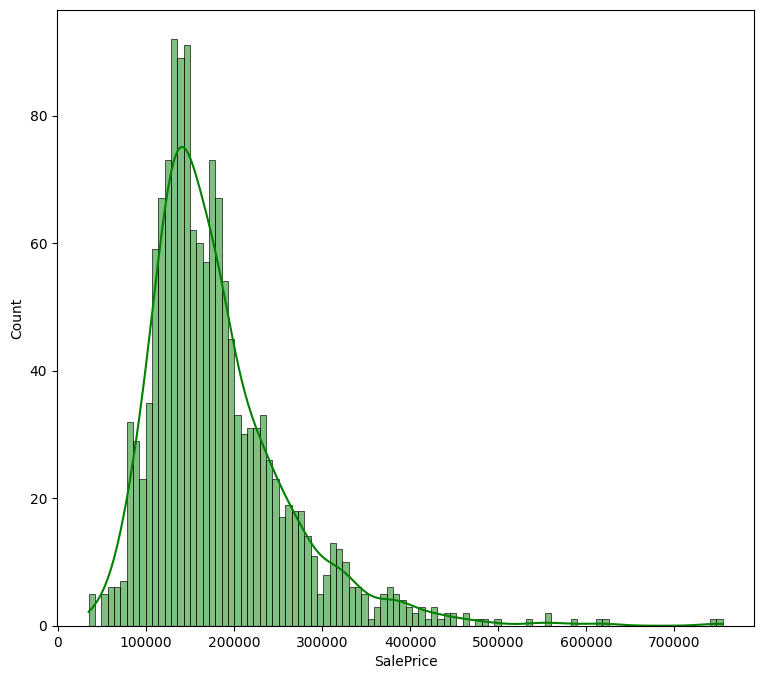

In [18]:
print(dataset_df["SalePrice"].describe())
plt.figure(figsize=(9, 8))
sns.histplot(dataset_df["SalePrice"], color="g", bins=100, kde=True, cbar_kws={'alpha':0.4})

## Numerical data distribution
- 숫자 타입 변수만 골라서 분포를 확인해줄것

In [19]:
list(set(dataset_df.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64')]

In [20]:
df_num = dataset_df.select_dtypes(include="number")
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


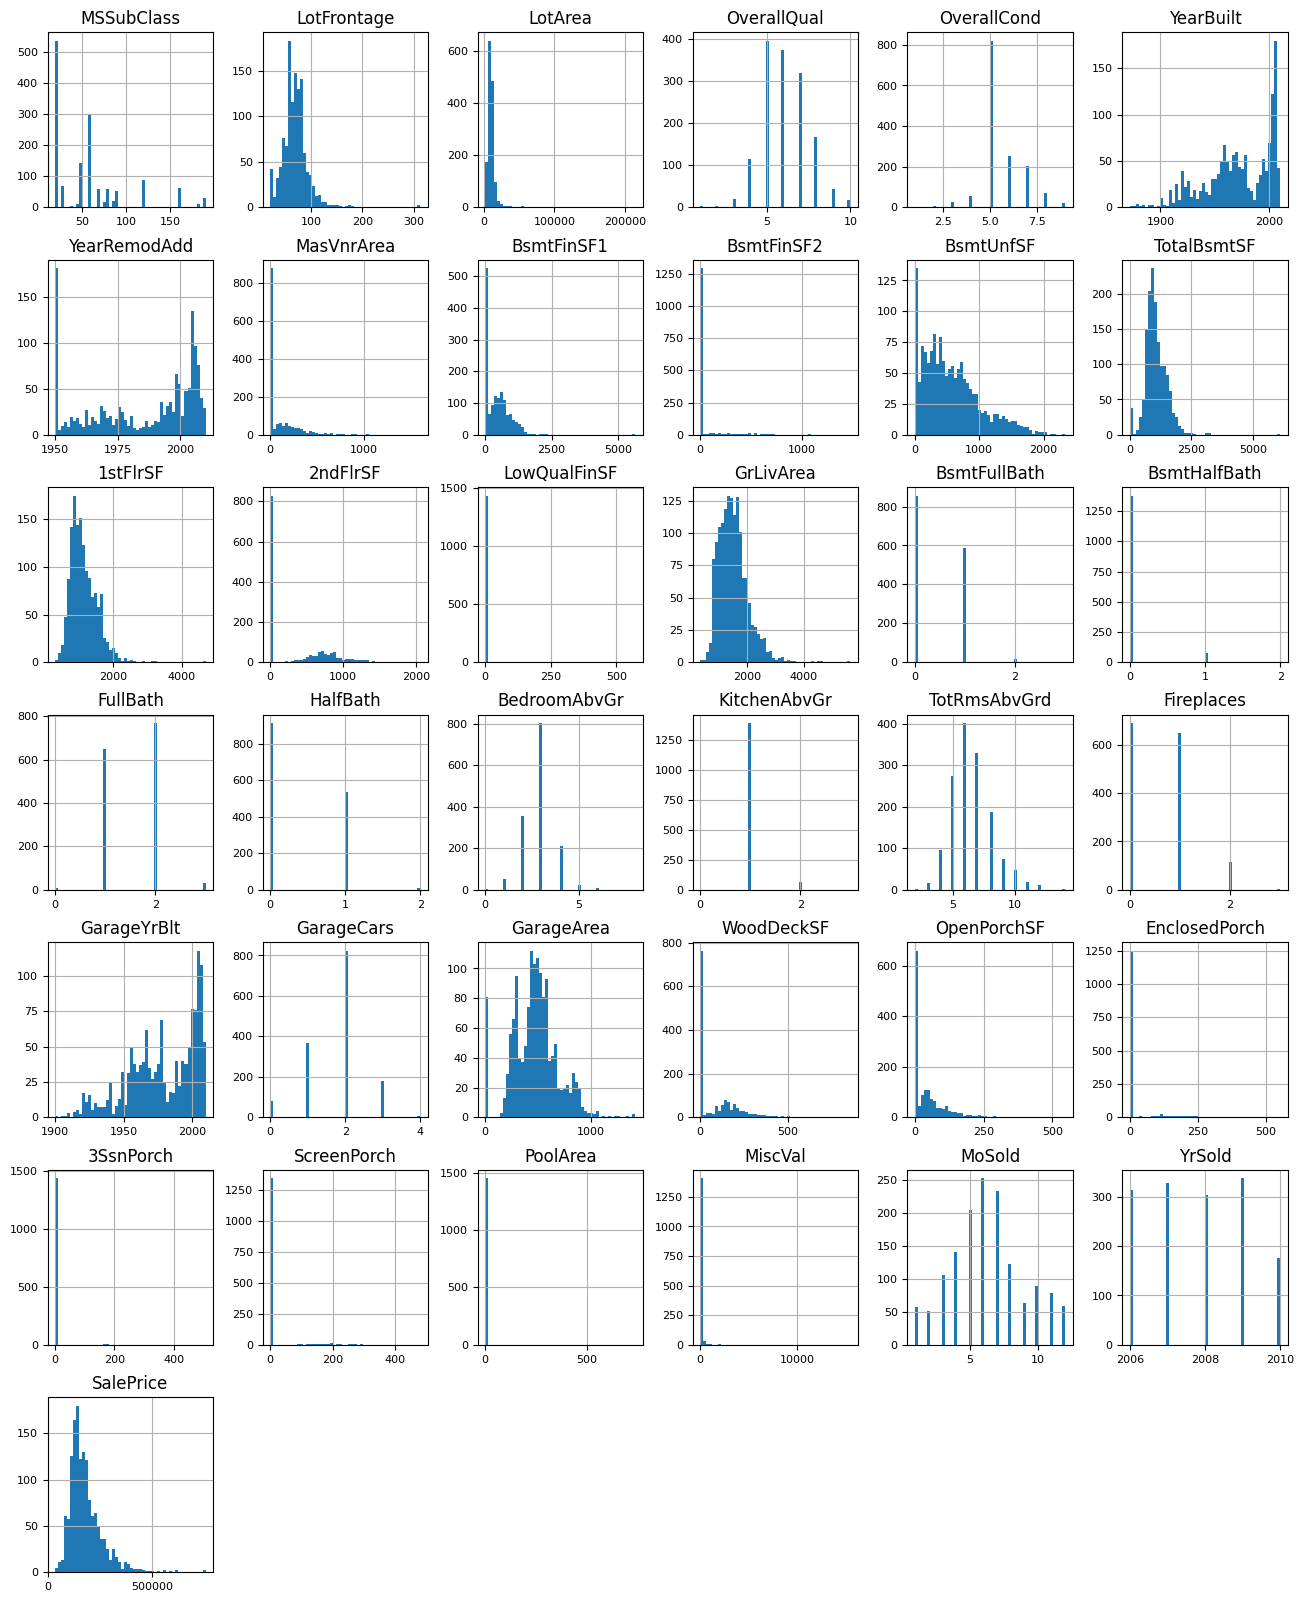

In [22]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Prepare the dataset

- 트리 기반 모델은 전처리 과정이 필요가 없다.
- 모든 데이터를 원천 데이터로 사용할 수 있는게 장점이다.

In [32]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1022 examples in training, 438 examples in testing.


tensorflow에서는 모델을 학습하기 위해선, pd.DataFrame을 tf.data.Dataset으로 변환해줘야됨

- 이를 위해선 우리는 Task의 타입을 지정해줘야됨
- 본 노트북에서 사용할 모델은 Regression이기에, task를 tfdf.keras.Task.REGRESSION으로 지정해줌
- tfdf = tensorflow_decision_forests

In [37]:
label = "SalePrice"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, 
                                                task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label,
                                                task = tfdf.keras.Task.REGRESSION)

## Select a Model

- RandomForestModel (selected)
- GradientBoostedTreesModel
- CartModel
- DistributionGradientBoostedTreesModel

In [34]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

### Create a Random Forest

In [35]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /tmp/tmpteqyv8k1 as temporary training directory


### Train the model

하나의 라인만 사용해서 모델을 학습시킬 수 있음

In [38]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:08.256301. Found 1022 examples.
Training model...


[INFO 24-02-04 16:56:47.6797 UTC kernel.cc:1233] Loading model from path /tmp/tmpteqyv8k1/model/ with prefix 9327f3e190e24a26


Model trained in 0:00:02.130194
Compiling model...


[INFO 24-02-04 16:56:48.0734 UTC decision_forest.cc:660] Model loaded with 300 root(s), 97180 node(s), and 74 input feature(s).
[INFO 24-02-04 16:56:48.0735 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-02-04 16:56:48.0736 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


### Visualize the model

In [39]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

## Evaluate the model on Out of bag(OOB) data and the validation dataset

- Validation dataset (valid_ds)과 OOB score를 활용해서 모델을 평가할 것
- train dataset은 RMSE를 바탕으로 학습되었음

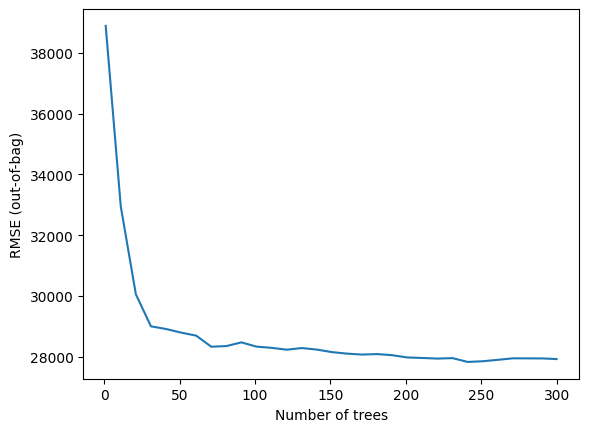

In [40]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])

plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [42]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1022, accuracy=None, loss=None, rmse=27919.577670972423, ndcg=None, aucs=None, auuc=None, qini=None)

- Validation을 통해 모델을 평가해보자

In [43]:
evaluation = rf.evaluate(x=valid_ds, return_dict=True)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 823ms/step - loss: 0.0000e+00 - mse: 1147264768.0000
loss: 0.0000
mse: 1147264768.0000


### Varible importances
- 변수의 중요도는 각 피처가 모델 예측에 얼마나 잘 활용되었는지를 나타내는 것

In [44]:
print(f"Available variable importances")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

Available variable importances
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_NODES
	 NUM_AS_ROOT


In [46]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 113.0),
 ("ExterQual" (4; #22), 68.0),
 ("Neighborhood" (4; #59), 32.0),
 ("GarageCars" (1; #32), 23.0),
 ("YearBuilt" (1; #76), 14.0),
 ("KitchenQual" (4; #44), 13.0),
 ("TotalBsmtSF" (1; #73), 13.0),
 ("GrLivArea" (1; #38), 12.0),
 ("BsmtQual" (4; #14), 6.0),
 ("GarageArea" (1; #31), 3.0),
 ("1stFlrSF" (1; #0), 1.0),
 ("BsmtFinSF1" (1; #8), 1.0),
 ("GarageYrBlt" (1; #37), 1.0)]

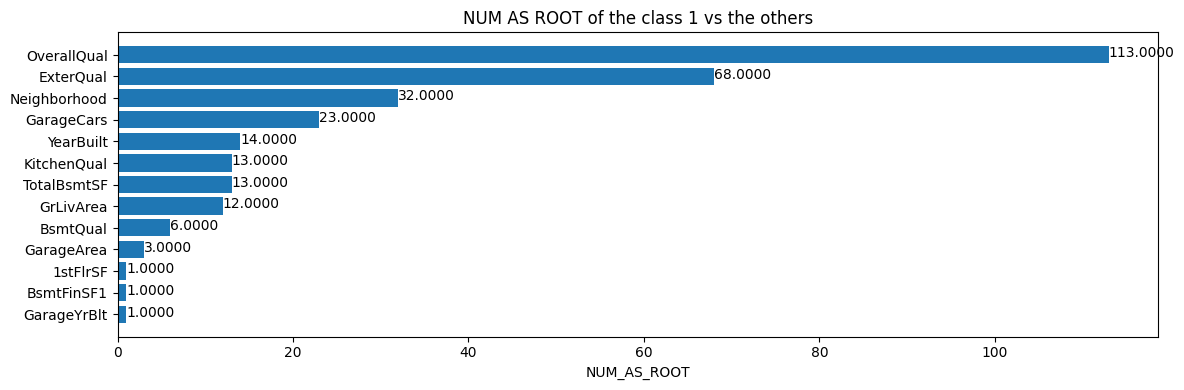

In [48]:
plt.figure(figsize=(12, 4))

variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]

feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")
    
plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

## Submissoin

In [49]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"

test_data = pd.read_csv(test_file_path)
ids = test_data.pop("Id")

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
            test_data,
            task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({"Id": ids,
                       "SalePrice" : preds.squeeze()})

output.head()

2/2 [==============================] - 1s 23ms/step


,Id,SalePrice
0,1461,123406.164062
1,1462,156117.437500
2,1463,180273.890625
3,1464,181748.328125
4,1465,195135.640625


In [50]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 23ms/step


,Id,SalePrice
0,1461,123406.164062
1,1462,156117.437500
2,1463,180273.890625
3,1464,181748.328125
4,1465,195135.640625
